AI-Driven Risk Prediction Engine for Chronic Care Patients

Install & Import Libraries

In [1]:
!pip install lightgbm -q

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report


**PREPROCESSING**

Load Dataset

In [2]:
df = pd.read_csv("/content/mimic_dataset.csv")


Drop Unnecessary Column:


remove identifiers and irrelevant columns


In [3]:
drop_cols = ["subject_id", "hadm_id", "admittime", "source"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])


Encode Gender Column:

converting categorical variable into numeric

In [4]:
if "gender" in df.columns:
    df["gender"] = LabelEncoder().fit_transform(df["gender"])  # M=1, F=0


Encode Other Categorical Columns:

converting all string/object columns except the target into numbers

In [5]:
for col in df.select_dtypes(include=["object"]).columns:
    if col != "outcome_90d":  # don't touch target
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))


Define Features & Target

In [6]:
target_col = "outcome_90d"
feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols]
y = df[target_col]


Train-Validation-Test Split

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)


Handle Missing Values (Imputation)

In [8]:
train_medians = X_train.median(numeric_only=True)
X_train = X_train.fillna(train_medians)
X_val   = X_val.fillna(train_medians)
X_test  = X_test.fillna(train_medians)


**Modeling**

First LightGBM Model

In [9]:
from lightgbm import early_stopping, log_evaluation

model = lgb.LGBMClassifier()

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(100)]
)


[LightGBM] [Info] Number of positive: 470, number of negative: 463
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3035
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503751 -> initscore=0.015006
[LightGBM] [Info] Start training from score 0.015006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.0847857
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0839334


LGBMClassifier()

Define Callbacks (import)

In [10]:
from lightgbm import early_stopping, log_evaluation


Tuned LightGBM Model

In [11]:
model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=-1,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(50)]
)


[LightGBM] [Info] Number of positive: 470, number of negative: 463
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3035
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.01, n_estimators=1000, num_leaves=64,
               random_state=42, subsample=0.8)

**Evaluation**

Predictions & Metrics

In [12]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("✅ Model Evaluation Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUROC:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


✅ Model Evaluation Results
Accuracy: 0.9651741293532339
AUROC: 0.9922772277227723
Confusion Matrix:
 [[ 94   6]
 [  1 100]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       100
           1       0.94      0.99      0.97       101

    accuracy                           0.97       201
   macro avg       0.97      0.97      0.97       201
weighted avg       0.97      0.97      0.97       201



**Visualization**

Import Viz Libraries

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt


Confusion Matrix Plot

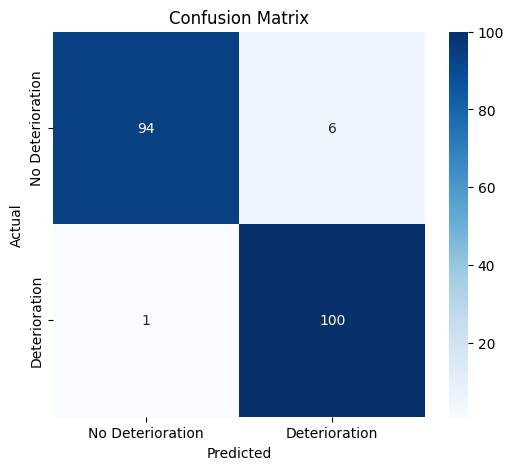

In [14]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Deterioration", "Deterioration"],
            yticklabels=["No Deterioration", "Deterioration"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Import Extra Libraries for ROC, SHAP, Saving

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import shap
import joblib


ROC & Precision-Recall Curves

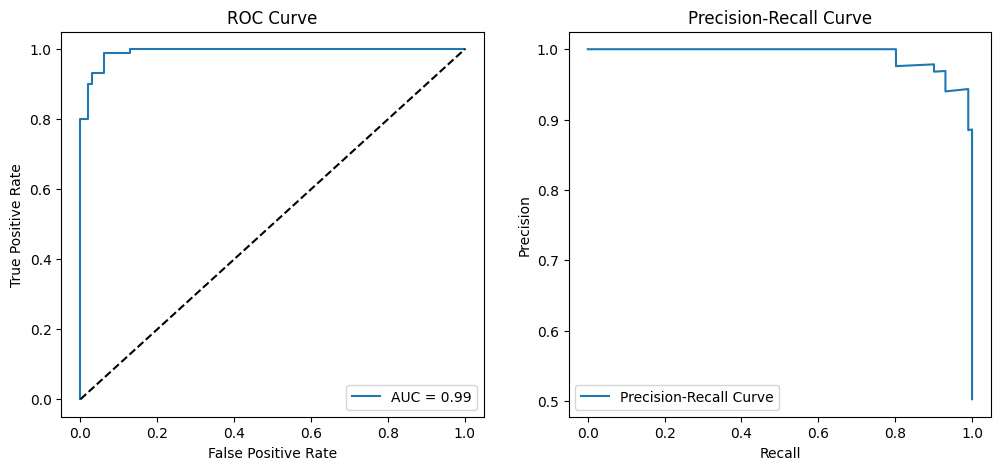

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.show()


**Interpretability**

SHAP Explainer Setup

In [17]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


SHAP Summary Plot (Bar Chart)

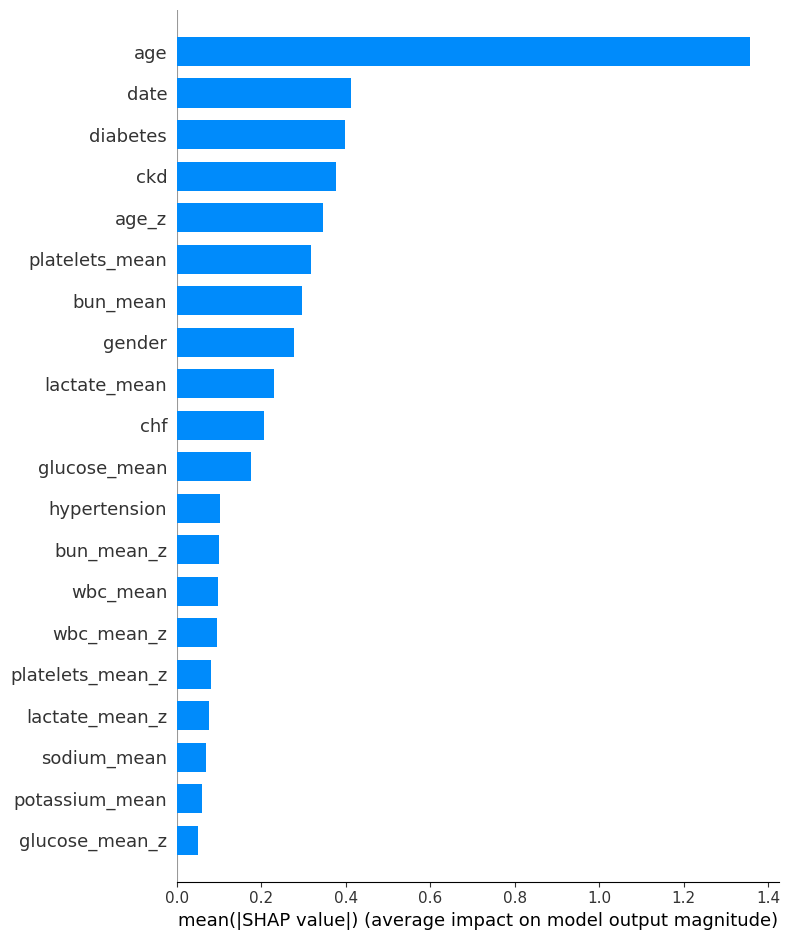

In [18]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


SHAP Summary Plot (Detailed Beeswarm)

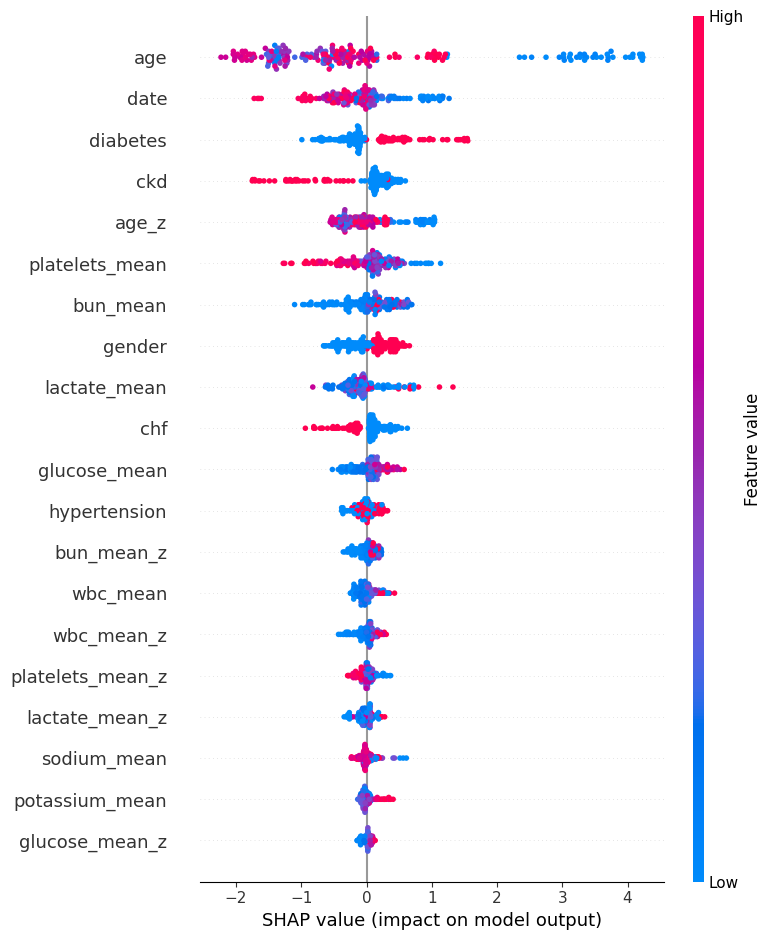

In [19]:
shap.summary_plot(shap_values, X_test)


SHAP Force Plot for One Example

In [21]:
sample_idx = 0
shap.initjs()

# Handle binary vs multiclass automatically
if isinstance(explainer.expected_value, list):
    # Multiclass case → pick class 1 (positive class)
    shap.force_plot(
        explainer.expected_value[1],
        shap_values[1][sample_idx],
        X_test.iloc[sample_idx]
    )
else:
    # Binary case → no class index
    shap.force_plot(
        explainer.expected_value,
        shap_values[sample_idx],
        X_test.iloc[sample_idx]
    )



**Deployment / Model Saving**

Save Model & Feature Columns

In [22]:
# Save the trained model
joblib.dump(model, "risk_prediction_model.pkl")

# Save the feature names used during training
feature_columns = X_train.columns.tolist()
joblib.dump(feature_columns, "feature_columns.pkl")

print("✅ Model saved as risk_prediction_model.pkl")
print("✅ Feature columns saved as feature_columns.pkl")


✅ Model saved as risk_prediction_model.pkl
✅ Feature columns saved as feature_columns.pkl


Load Model & Feature Columns Back

In [23]:
# Load model
loaded_model = joblib.load("risk_prediction_model.pkl")

# Load feature columns
loaded_features = joblib.load("feature_columns.pkl")

print("🔄 Loaded feature columns match training:", loaded_features == feature_columns)


🔄 Loaded feature columns match training: True


Verify Loaded Model Predictions

In [24]:
y_loaded_pred = loaded_model.predict(X_test[loaded_features])
print("Loaded Model Accuracy:", accuracy_score(y_test, y_loaded_pred))


Loaded Model Accuracy: 0.9651741293532339
